[INFO] Wycięto fragment od 4s do 7s (4801 próbek)


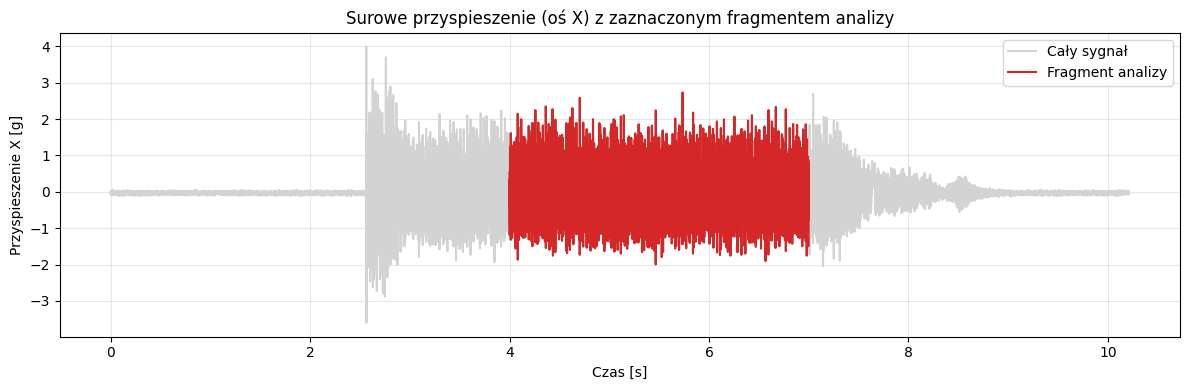

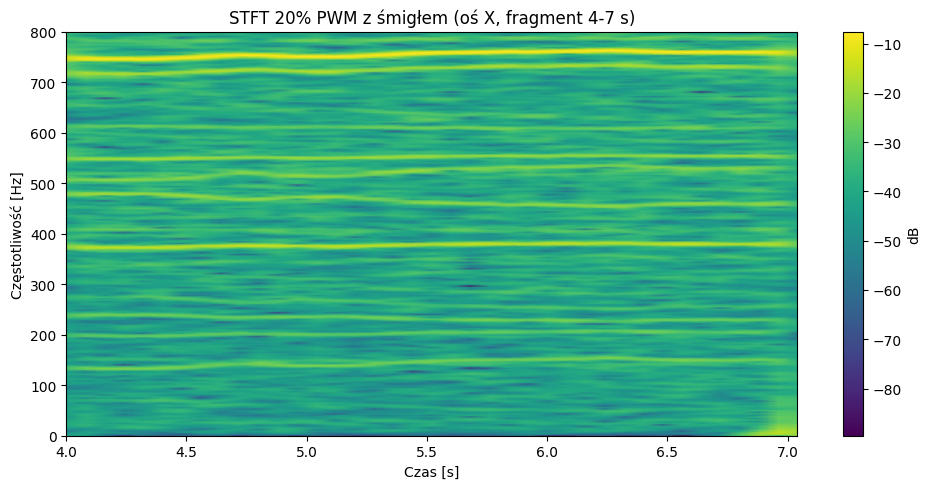

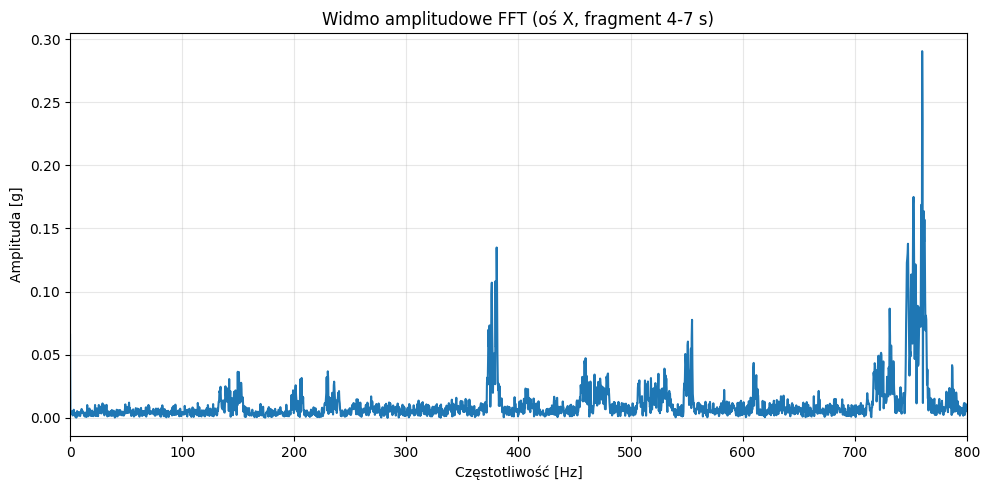

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

fs = 1600           # częstotliwość próbkowania [Hz]
lsb_to_g = 0.0039   # przelicznik LSB -> g (FULL_RES = 3.9 mg/LSB)

# Wczytanie danych
df = pd.read_csv('data/pomiar_z_20.csv')

df['X_g'] = df['X'] * lsb_to_g
t = df['czas [s]'].to_numpy()
x_raw = df['X_g'].to_numpy()

# przedział analizy
t_start = 4
t_end   = 7
mask = (t >= t_start) & (t <= t_end)
t_seg = t[mask]
x_seg = x_raw[mask]

print(f"[INFO] Wycięto fragment od {t_start}s do {t_end}s ({len(x_seg)} próbek)")

# Wykres badanego sygnału
plt.figure(figsize=(12, 4))
plt.plot(t, x_raw, color='lightgray', label='Cały sygnał')
plt.plot(t_seg, x_seg, color='#d62728', label='Fragment analizy')
plt.xlabel('Czas [s]')
plt.ylabel('Przyspieszenie X [g]')
plt.title('Surowe przyspieszenie (oś X) z zaznaczonym fragmentem analizy')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Usunięcie biasu z wycinka
N0 = int(min(len(x_seg), 2 * fs))
bias = np.mean(x_seg[:N0])
x0 = x_seg - bias

# Filtr high-pass (usunięcie grawitacji)
fc = 5.0
b, a = signal.butter(2, fc / (fs / 2), btype='highpass')
x_hp = signal.filtfilt(b, a, x0)

# Analiza czasowo-częstotliwościowa (STFT)
f, tt, Sxx = signal.stft(x_hp, fs=fs, window='hann', nperseg=512, noverlap=384)
plt.figure(figsize=(10, 5))
plt.pcolormesh(tt + t_start, f, 20*np.log10(np.abs(Sxx)), shading='gouraud')
plt.ylim(0, 800)
plt.xlabel('Czas [s]')
plt.ylabel('Częstotliwość [Hz]')
plt.title(f'STFT 20% PWM z śmigłem (oś X, fragment {t_start}-{t_end} s)')
plt.colorbar(label='dB')
plt.tight_layout()
plt.show()

# Widmo (FFT)
N = len(x_seg)
T = 1 / fs
Xf = np.fft.fft(x_seg)
freqs = np.fft.fftfreq(N, T)

pos_mask = freqs >= 0
freqs = freqs[pos_mask]
amp = 2.0 / N * np.abs(Xf[pos_mask])

plt.figure(figsize=(10,5))
plt.plot(freqs, amp, color='#1f77b4')
plt.xlim(0, 800)
plt.xlabel('Częstotliwość [Hz]')
plt.ylabel('Amplituda [g]')
plt.title(f'Widmo amplitudowe FFT (oś X, fragment {t_start}-{t_end} s)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()